In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import os
import glob
import itertools as it
import scipy.stats

In [7]:
IDIR = "."
DS = list(map(lambda _x: _x.split(".")[0], list(os.walk(os.path.join(IDIR, "mol_rt_info")))[0][2]))
DS.remove("all_rt_data")
print("Datasets", DS)

Datasets ['EQ_000', 'PR_000', 'RP_000', 'AU_000', 'BML_000', 'EQ_001', 'LU_000', 'LQB_000', 'EA_000', 'BS_000', 'UT_000', 'EA_001']


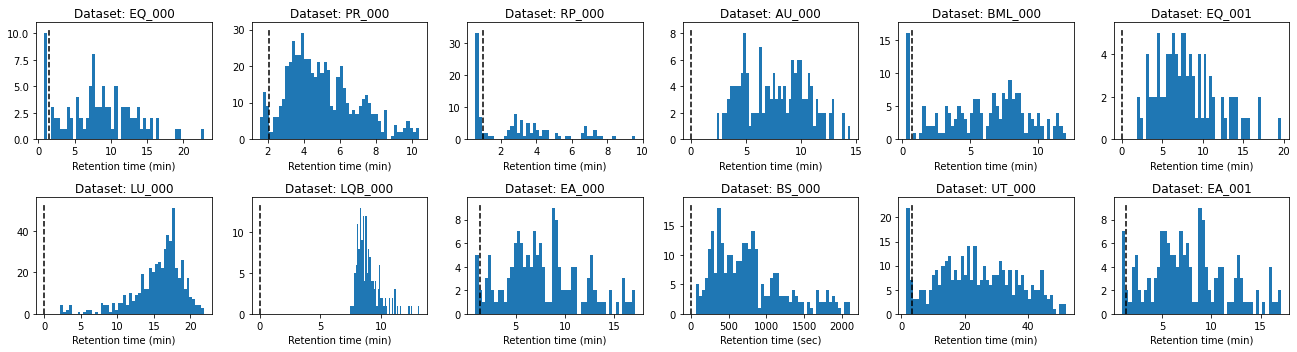

In [8]:
early_eluting_threshold = {
    "EQ_000": 1.5,
    "PR_000": 2.1,
    "RP_000": 1,
    "BML_000": 0.75,
    "UT_000": 3.3,
    "EA_000": 1.35,
    "EA_001": 1.35
}

fig, axrr = plt.subplots(2, len(DS) // 2, sharey=False, sharex=False, figsize=(18, 5))
for idx, ds in enumerate(DS):
    _df_rt = pd.read_csv(os.path.join(IDIR, "mol_rt_info", ds + ".csv"))
    r, c = np.unravel_index(idx, axrr.shape)
    axrr[r, c].hist(_df_rt["rt"], bins=50)
    _ymin, _ymax = axrr[r, c].get_ylim()
    axrr[r, c].vlines(early_eluting_threshold.get(ds, 0), _ymin, _ymax, "black", "--")
    axrr[r, c].set_title("Dataset: %s" % ds)
    axrr[r, c].set_xlabel("Retention time (%s)" % _df_rt["rt_unit"][0])
plt.tight_layout()

In [15]:
df = pd.DataFrame()

for ds in DS:
    # Load Retention Times
    _df_rt = pd.read_csv(os.path.join(IDIR, "mol_rt_info", ds + ".csv"), usecols=["pubchem_id", "smiles_iso", "inchikey", "rt"]) \
        .assign(dataset=ds) \
        .groupby(["pubchem_id", "smiles_iso", "inchikey"]) \
        .aggregate(np.min) \
        .reset_index()
    _df_rt = _df_rt[_df_rt["rt"] >= early_eluting_threshold.get(ds, 0)]
    _df_rt = _df_rt.assign(inchikey1=[ikey.split("-")[0] for ikey in _df_rt.inchikey])
    
    assert len(_df_rt.inchikey.unique()) == len(_df_rt)
    
    
    # Load classyfire classes
    _df_cls = pd.read_csv(os.path.join(IDIR, "classyfire", ds + ".classes"), usecols=["pubchem_id", "superclass", "class", "subclass"]) \
        .assign(dataset=ds) \
        .drop_duplicates() \
        .dropna(subset=["superclass", "class", "subclass"])
    
    df = pd.concat((df, pd.merge(_df_rt, _df_cls, how="inner", on=["pubchem_id", "dataset"])), axis=0, sort=False)
    
assert not any(df.isna().any())
    
df.to_csv(os.path.join("mol_rt_info", "all_rt_data.csv"), index=False)

print(df.head())

   pubchem_id                                         smiles_iso  \
0        1775          C1=CC=C(C=C1)C2(C(=O)NC(=O)N2)C3=CC=CC=C3   
1        1981  CC1=C(C2=C(N1C(=O)C3=CC=C(C=C3)Cl)C=CC(=C2)OC)...   
2        1986                       CC(=O)NC1=NN=C(S1)S(=O)(=O)N   
3        2466                         CCCCOC1=CC=C(C=C1)CC(=O)NO   
4        2663  CCN(CC)C(=O)NC1=CC(=C(C=C1)OCC(CNC(C)(C)C)O)C(...   

                      inchikey    rt dataset       inchikey1  \
0  CXOFVDLJLONNDW-UHFFFAOYSA-N   7.6  EQ_000  CXOFVDLJLONNDW   
1  FSQKKOOTNAMONP-UHFFFAOYSA-N  12.8  EQ_000  FSQKKOOTNAMONP   
2  BZKPWHYZMXOIDC-UHFFFAOYSA-N   2.4  EQ_000  BZKPWHYZMXOIDC   
3  MXJWRABVEGLYDG-UHFFFAOYSA-N   8.4  EQ_000  MXJWRABVEGLYDG   
4  JOATXPAWOHTVSZ-UHFFFAOYSA-N   5.5  EQ_000  JOATXPAWOHTVSZ   

                     superclass                                class  \
0  Organoheterocyclic compounds                           Azolidines   
1  Organoheterocyclic compounds              Indoles and deriv